In [1]:
import pandas as pd
import numpy as np

import ast
import torch

from utils.interactive_plot import plot_embeddings_interactive
from utils.kl_divergence import compute_kls
from utils.dimension_reduction import get_tsne_embeddings

audio = pd.read_csv("data/audio.csv")
lyrics = pd.read_csv("data/lyrics.csv")
full = pd.read_csv("data/full.csv")

full["sqrt_wks"] = full["wks_on_chart"].apply(lambda x: np.sqrt(x))
full['wks_bucketed'] = full['sqrt_wks'].astype(int)

to_merge = ['track_name', 'wks_on_chart', 'sqrt_wks', 'wks_bucketed', 'key', 'key_mode']

audio = audio.merge(full[to_merge], on='track_name', how='left')
lyrics = lyrics.merge(full[to_merge], on='track_name', how='left')

2024-04-23 13:29:55.592476: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def list_to_tensor(lst):
    if lst is not None:
        return torch.tensor([float(x) for x in lst.strip("[]").split(",") if x])
    else:
        return None

audio['latent_audio'] = audio['latent_audio'].apply(lambda x: list_to_tensor(x) if pd.notnull(x) else None)
lyrics['latent_embedding'] = lyrics['latent_embedding'].apply(lambda x: torch.tensor(ast.literal_eval(x)))

In [3]:
compute_kls(audio, "wks_on_chart")

The cluster most similar to the overall distribution is: 0
KL Divergences by cluster:
Cluster 0: 0.2110428290889822
Cluster 6: 0.25427667087705697
Cluster 7: 0.27770737279481517
Cluster 9: 0.2882718861480844
Cluster 12: 0.34802911098494427
Cluster 1: 0.4009614888979761
Cluster 5: 0.44810921873213877
Cluster 4: 0.46431604351138084
Cluster 14: 0.4757839799037803
Cluster 10: 0.5734805843645955
Cluster 8: 0.5971418191334149
Cluster 13: 0.856317033055617
Cluster 11: 1.1325952436656401
Cluster 2: 1.2576571152366296
Cluster 3: 1.702261692267202


In [4]:
compute_kls(lyrics, "wks_on_chart")

The cluster most similar to the overall distribution is: 3
KL Divergences by cluster:
Cluster 3: 0.23379734932819404
Cluster 14: 0.28937617946640015
Cluster 0: 0.3260878037577486
Cluster 10: 0.3322540618378864
Cluster 7: 0.34538143848009495
Cluster 8: 0.36509220740021675
Cluster 1: 0.3816692846274304
Cluster 6: 0.42861129278253285
Cluster 9: 0.44747640680663886
Cluster 5: 0.5096761503616904
Cluster 12: 0.5670417761316591
Cluster 13: 1.1485117979548258
Cluster 2: 1.2639310676053295
Cluster 4: 1.5725192807267954
Cluster 11: 1.801134277872217


In [5]:
audio_embeddings = get_tsne_embeddings(audio, "latent_audio")
lyric_embeddings = get_tsne_embeddings(lyrics, "latent_embedding")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [6]:
plot_embeddings_interactive(audio, audio_embeddings, "cluster_assignment")

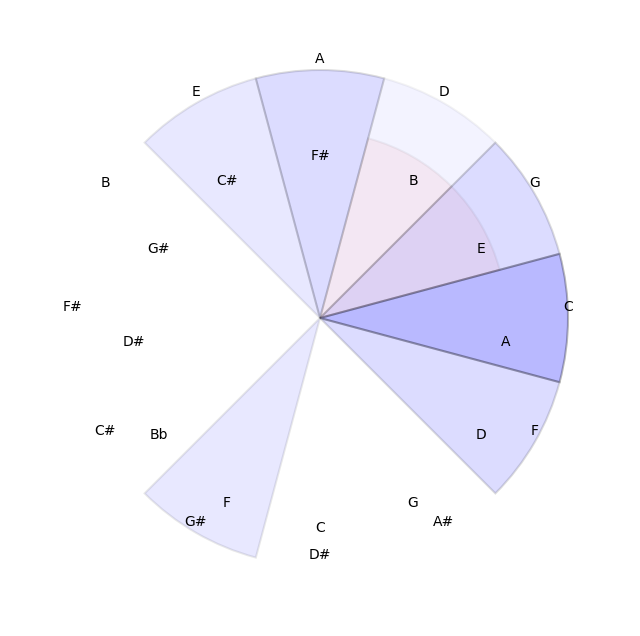

In [91]:
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from collections import Counter

def plot_circle_of_fifths(audio, cluster):
    # Filter dataframe by cluster
    cluster_data = audio[audio['cluster_assignment'] == cluster]
    # Drop any rows with NaN values in 'key_mode'
    cluster_data = cluster_data.dropna(subset=['key_mode'])

    # Split 'key_mode' into note and mode
    cluster_data['note'], cluster_data['mode'] = zip(*cluster_data['key_mode'].apply(lambda x: x.split(' ')))

    # Count frequencies of each key in this cluster
    key_counts = Counter(cluster_data['key_mode'])

    # Define the circle of fifths
    major_keys = ['C major', 'G major', 'D major', 'A major', 'E major', 'B major', 'F# major', 'C# major', 'G# major', 'D# major', 'A# major', 'F major']
    minor_keys = ['A minor', 'E minor', 'B minor', 'F# minor', 'C# minor', 'G# minor', 'D# minor', 'Bb minor', 'F minor', 'C minor', 'G minor', 'D minor']

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal', adjustable='datalim')
    plt.axis('off')

    # Function to draw wedge and text
    def draw_wedge(angle, radius, label, color, alpha):
        wedge = Wedge((0, 0), radius, angle - 15, angle + 15, color=color, alpha=alpha, ec="black", linewidth=1.5)
        ax.add_patch(wedge)
        x, y = np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle))
        ax.annotate(label, (radius * x, radius * y), textcoords="offset points", xytext=(0, 5 if radius > 1 else -20), ha='center', color='black')

    # Plot major keys
    for i, key in enumerate(major_keys):
        angle = i * 30
        alpha = key_counts.get(key, 0) / cluster_data['key_mode'].count() if cluster_data['key_mode'].count() > 0 else 0
        draw_wedge(angle, 1.2, key.split()[0], 'blue', alpha)

    # Plot minor keys
    for i, key in enumerate(minor_keys):
        angle = i * 30
        alpha = key_counts.get(key, 0) / cluster_data['key_mode'].count() if cluster_data['key_mode'].count() > 0 else 0
        draw_wedge(angle, 0.9, key.split()[0], 'red', alpha)

    plt.show()

plot_circle_of_fifths(audio, 5)

In [116]:
audio[audio["cluster_assignment"] == 13]

,track_name,peak_pos,album_name,key_x,tempo,video_url,latent_audio,peak_pos_bucketed,cluster_assignment,wks_on_chart,sqrt_wks,wks_bucketed,key_y,key_mode
268,Tell Me Why,NaN,Fearless,7.0,100.015,https://www.youtube.com/watch?v=cwFbq-70EwE,"[tensor(-0.1233), tensor(0.0570), tensor(0.037...",>100,13,0,0.000000,0,7.0,G major
269,Tell Me Why (Taylor's Version),NaN,Fearless (Taylor's Version),7.0,100.023,https://www.youtube.com/watch?v=cwFbq-70EwE,"[tensor(-0.1233), tensor(0.0570), tensor(0.037...",>100,13,0,0.000000,0,7.0,G major
310,Untouchable,19.0,Fearless,5.0,200.017,https://www.youtube.com/watch?v=8bNlGwnEUAs,"[tensor(-0.1790), tensor(0.0578), tensor(0.071...",10-19,13,2,1.414214,1,5.0,F major
311,Untouchable (Taylor's Version),NaN,Fearless (Taylor's Version),5.0,200.391,https://www.youtube.com/watch?v=8bNlGwnEUAs,"[tensor(-0.1790), tensor(0.0578), tensor(0.071...",>100,13,0,0.000000,0,5.0,F major


In [111]:
lyrics[lyrics["cluster_assignment"] == 14]

,track_name,peak_pos,album_name,lyrics,peak_pos_bucketed,latent_embedding,cluster_assignment,wks_on_chart,sqrt_wks,wks_bucketed,key,key_mode
5,A Perfectly Good Heart,NaN,Taylor Swift,why would you wanna break a perfectly good hea...,>100,"[tensor(0.0702), tensor(0.3086), tensor(0.2394...",14,0,0.000000,0,4.0,E major
14,American Girl,NaN,NaN,"well, she was an american girl raised on promi...",>100,"[tensor(0.0015), tensor(0.3198), tensor(0.2606...",14,0,0.000000,0,NaN,NaN
35,Birch,NaN,NaN,the way i woke up was old was all fucking chok...,>100,"[tensor(0.0309), tensor(0.2638), tensor(0.1602...",14,0,0.000000,0,8.0,G# major
44,Carolina,60.0,NaN,"oh, carolina creeks running through my veins l...",60-69,"[tensor(0.0824), tensor(0.4808), tensor(0.0678...",14,1,1.000000,1,11.0,B minor
51,Christmases When You Were Mine,NaN,The Taylor Swift Holiday Collection,please take down the mistletoe 'cause i don't ...,>100,"[tensor(0.0936), tensor(0.4391), tensor(0.1229...",14,0,0.000000,0,7.0,G major
55,Cold As You,NaN,Taylor Swift,you have a way of coming easily to me and when...,>100,"[tensor(-0.0839), tensor(0.5062), tensor(-0.01...",14,0,0.000000,0,5.0,F major
58,Come In With The Rain,30.0,Fearless,i could go back to every laugh but i don't wan...,30-39,"[tensor(0.2238), tensor(0.3906), tensor(-0.081...",14,1,1.000000,1,2.0,D major
59,Come In With The Rain (Taylor's Version),NaN,Fearless (Taylor's Version),i could go back to every laugh but i don't wan...,>100,"[tensor(0.2201), tensor(0.3877), tensor(-0.068...",14,0,0.000000,0,2.0,D major
63,Crazier,17.0,NaN,i'd never gone with the wind just let it flow ...,10-19,"[tensor(-0.0263), tensor(0.3384), tensor(-0.13...",14,8,2.828427,2,4.0,E major
69,Dear Reader,45.0,Midnights,"dear reader, if it feels like a trap you're al...",40-49,"[tensor(0.0507), tensor(0.4497), tensor(-0.266...",14,2,1.414214,1,0.0,C major


In [7]:
plot_embeddings_interactive(lyrics, lyric_embeddings, "cluster_assignment")

In [8]:
full['isVault'] = full['track_name'].apply(lambda x: 1 if "[From The Vault]" in x else 0)

red = full[full["album_name"] == "Red"]
redtv = full[(full["album_name"] == "Red (Taylor's Version)") & (full["isVault"] == 0)]
redvault = full[(full["album_name"] == "Red (Taylor's Version)") & (full["isVault"] == 1)]

fear = full[full["album_name"] == "Fearless"]
feartv = full[(full["album_name"] == "Fearless (Taylor's Version)") & (full["isVault"] == 0)]
fearvault = full[(full["album_name"] == "Fearless (Taylor's Version)") & (full["isVault"] == 1)]

nine = full[full["album_name"] == "1989"]
ninetv = full[(full["album_name"] == "1989 (Taylor's Version)") & (full["isVault"] == 0)]
ninevault = full[(full["album_name"] == "1989 (Taylor's Version)") & (full["isVault"] == 1)]

speak = full[full["album_name"] == "Speak Now"]
speaktv = full[(full["album_name"] == "Speak Now (Taylor's Version)") & (full["isVault"] == 0)]
speakvault = full[(full["album_name"] == "Speak Now (Taylor's Version)") & (full["isVault"] == 1)]

In [9]:
dataframes = [red, redtv, fear, feartv, nine, ninetv, speak, speaktv]
names = ["Red", "Red (Taylor's Version)", "Fearless", "Fearless (Taylor's Version)",
         "1989", "1989 (Taylor's Version)", "Speak Now", "Speak Now (Taylor's Version)"]

proportions = {}
for name, df in zip(names, dataframes):
    total_entries = len(df)
    more_than_3_weeks = len(df[df['wks_on_chart'] > 0])
    proportion = more_than_3_weeks / total_entries if total_entries else 0
    proportions[name] = proportion

proportions

{'Red': 0.5,
 "Red (Taylor's Version)": 0.8571428571428571,
 'Fearless': 0.8421052631578947,
 "Fearless (Taylor's Version)": 0.3,
 '1989': 0.5625,
 "1989 (Taylor's Version)": 0.9444444444444444,
 'Speak Now': 1.0,
 "Speak Now (Taylor's Version)": 1.0}

In [10]:
proportions = {}
for name, df in zip(names, dataframes):
    total_entries = len(df)
    more_than_3_weeks = len(df[df['wks_on_chart'] > 2])
    proportion = more_than_3_weeks / total_entries if total_entries else 0
    proportions[name] = proportion

proportions

{'Red': 0.2727272727272727,
 "Red (Taylor's Version)": 0.047619047619047616,
 'Fearless': 0.47368421052631576,
 "Fearless (Taylor's Version)": 0.0,
 '1989': 0.375,
 "1989 (Taylor's Version)": 0.3333333333333333,
 'Speak Now': 0.4117647058823529,
 "Speak Now (Taylor's Version)": 0.0625}

In [11]:
dataframes = [redvault, redtv, fearvault, feartv, ninevault, ninetv, speakvault, speaktv]
names = ["Red (Vault Songs)", "Red (Taylor's Version)", "Fearless (Vault Songs)", "Fearless (Taylor's Version)",
         "1989 (Vault Songs)", "1989 (Taylor's Version)", "Speak Now (Vault Songs)", "Speak Now (Taylor's Version)"]

proportions = {}
for name, df in zip(names, dataframes):
    total_entries = len(df)
    more_than_3_weeks = len(df[df['wks_on_chart'] > 0])
    proportion = more_than_3_weeks / total_entries if total_entries else 0
    proportions[name] = proportion

proportions

{'Red (Vault Songs)': 0.8888888888888888,
 "Red (Taylor's Version)": 0.8571428571428571,
 'Fearless (Vault Songs)': 0.3333333333333333,
 "Fearless (Taylor's Version)": 0.3,
 '1989 (Vault Songs)': 1.0,
 "1989 (Taylor's Version)": 0.9444444444444444,
 'Speak Now (Vault Songs)': 1.0,
 "Speak Now (Taylor's Version)": 1.0}

/var/folders/fs/v9vqgp9d5zb2fzzy63_b2gcr0000gn/T/ipykernel_11673/1221811287.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



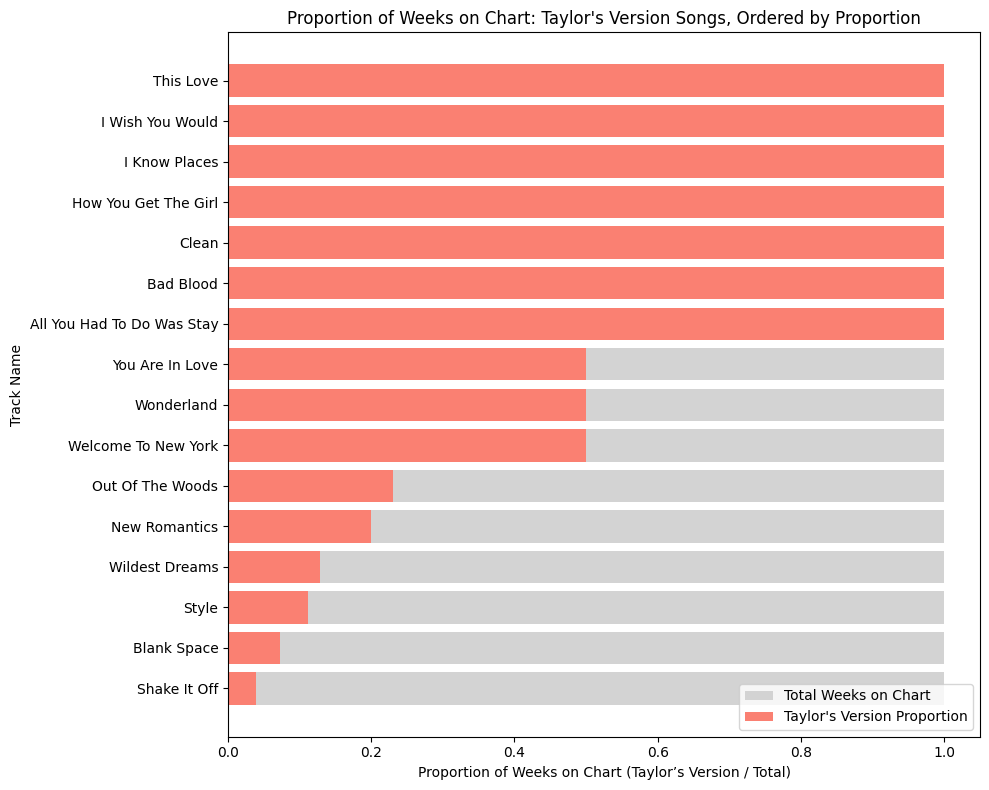

In [25]:
import matplotlib.pyplot as plt

# Filter albums
speak_now = full[full['album_name'] == "1989"]
speak_now_tv = full[full['album_name'] == "1989 (Taylor's Version)"]

# Prepare matching of songs from original and Taylor's Version by removing the "(Taylor's Version)" part from the track name
speak_now_tv['original_track_name'] = speak_now_tv['track_name'].str.replace(" \(Taylor's Version\)", "", regex=True)

# Merge the original and Taylor's Version on the track name
comparison_df = pd.merge(speak_now, speak_now_tv, left_on='track_name', right_on='original_track_name', suffixes=('', '_tv'))

comparison_df['total_wks_on_chart'] = comparison_df['wks_on_chart'] + comparison_df['wks_on_chart_tv']
comparison_df['tv_proportion'] = comparison_df['wks_on_chart_tv'] / comparison_df['total_wks_on_chart']

comparison_df_sorted = comparison_df.sort_values(by='tv_proportion', ascending=True)

# Plotting with sorted data
plt.figure(figsize=(10, 8))

# Background bars representing total potential weeks on chart
plt.barh(comparison_df_sorted['track_name'], 1, color='lightgrey', label='Total Weeks on Chart')

# Foreground bars representing the Taylor's Version proportion of total weeks on chart
plt.barh(comparison_df_sorted['track_name'], comparison_df_sorted['tv_proportion'], color='salmon', label="Taylor's Version Proportion")

plt.xlabel('Proportion of Weeks on Chart (Taylor’s Version / Total)')
plt.ylabel('Track Name')
plt.title("Proportion of Weeks on Chart: Taylor's Version Songs, Ordered by Proportion")
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

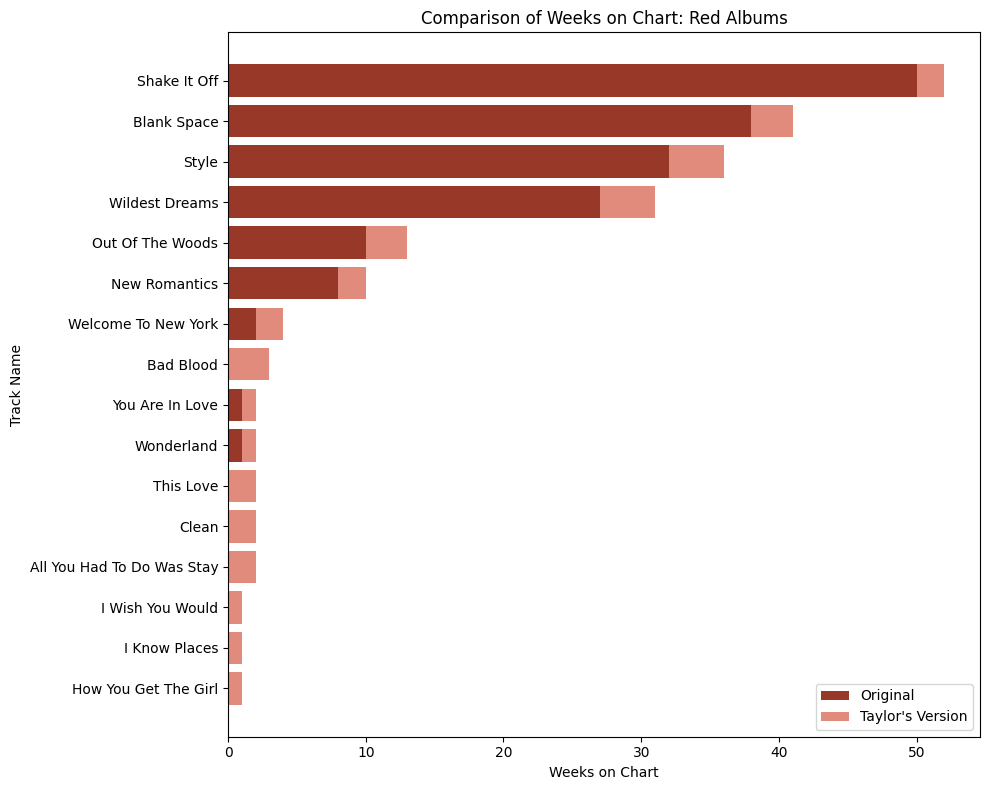

In [26]:
comparison_df_sorted = comparison_df.sort_values(by='total_wks_on_chart', ascending=True)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(comparison_df_sorted['track_name'], comparison_df_sorted['wks_on_chart'], color='#983828', label='Original')
plt.barh(comparison_df_sorted['track_name'], comparison_df_sorted['wks_on_chart_tv'], color='#e08b7b', left=comparison_df_sorted['wks_on_chart'], label="Taylor's Version")
plt.xlabel('Weeks on Chart')
plt.ylabel('Track Name')
plt.title("Comparison of Weeks on Chart: Red Albums")
plt.legend(loc='lower right')
plt.tight_layout()

# Show plot
plt.show()

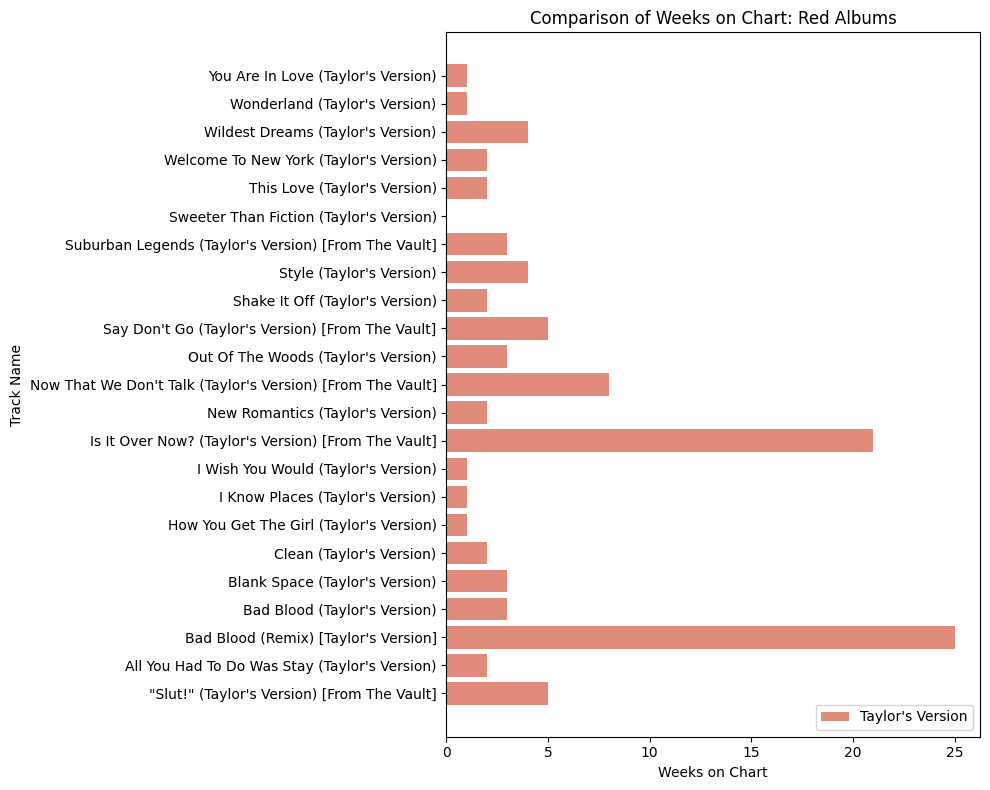

In [27]:
plt.figure(figsize=(10, 8))
plt.barh(speak_now_tv['track_name'], speak_now_tv['wks_on_chart'], color='#e08b7b', label="Taylor's Version")
plt.xlabel('Weeks on Chart')
plt.ylabel('Track Name')
plt.title("Comparison of Weeks on Chart: Red Albums")
plt.legend(loc='lower right')
plt.tight_layout()

# Show plot
plt.show()